In [62]:
import numpy as np
import scipy as sp
import time
from tqdm import tqdm

In [63]:
import env
import parallel_smd
import qvi
import smd

In [64]:
np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [65]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

In [66]:
def experiment(MDP, eps, n_samples, n_mixing, N_psmd, N_smd):
    empiricalMDP = env.EmpiricalMDP(MDP, n_samples)
    
    t_mix = MDP.mixing_time(n_mixing)
    print('Mixing time : {}'.format(t_mix))
    
    start_time = time.time()
    v_star = MDP.amdp_solve()
    print('Time for solving AMDP: {} sec.'.format(time.time() - start_time))
    
    np.random.seed(723)
    policies_psmd, times_psmd = parallel_smd.parallel_SMD(eps, N_psmd, MDP, empiricalMDP, t_mix, 1000)
    
    np.random.seed(723)
    policies_smd, times_smd = smd.SMD(eps, N_smd, MDP, t_mix, 1000)
    
    delta_psmd = []
    for pi in tqdm(policies_psmd):
        v_pi = MDP.amdp_value(pi)
        delta_psmd.append(v_star - v_pi)
        
    delta_smd = []
    for pi in tqdm(policies_smd):
        v_pi = MDP.amdp_value(pi)
        delta_smd.append(v_star - v_pi)
        
    return delta_psmd, delta_smd, times_psmd, times_smd

# Experiment #2: RiverSwim

In [67]:
rswim = env.RiverSwim()

In [68]:
delta_psmd, delta_smd, times_psmd, times_smd = experiment(
    rswim, eps=1e-2, n_samples=1000, n_mixing=1000, N_psmd=100000000, N_smd=100000000)

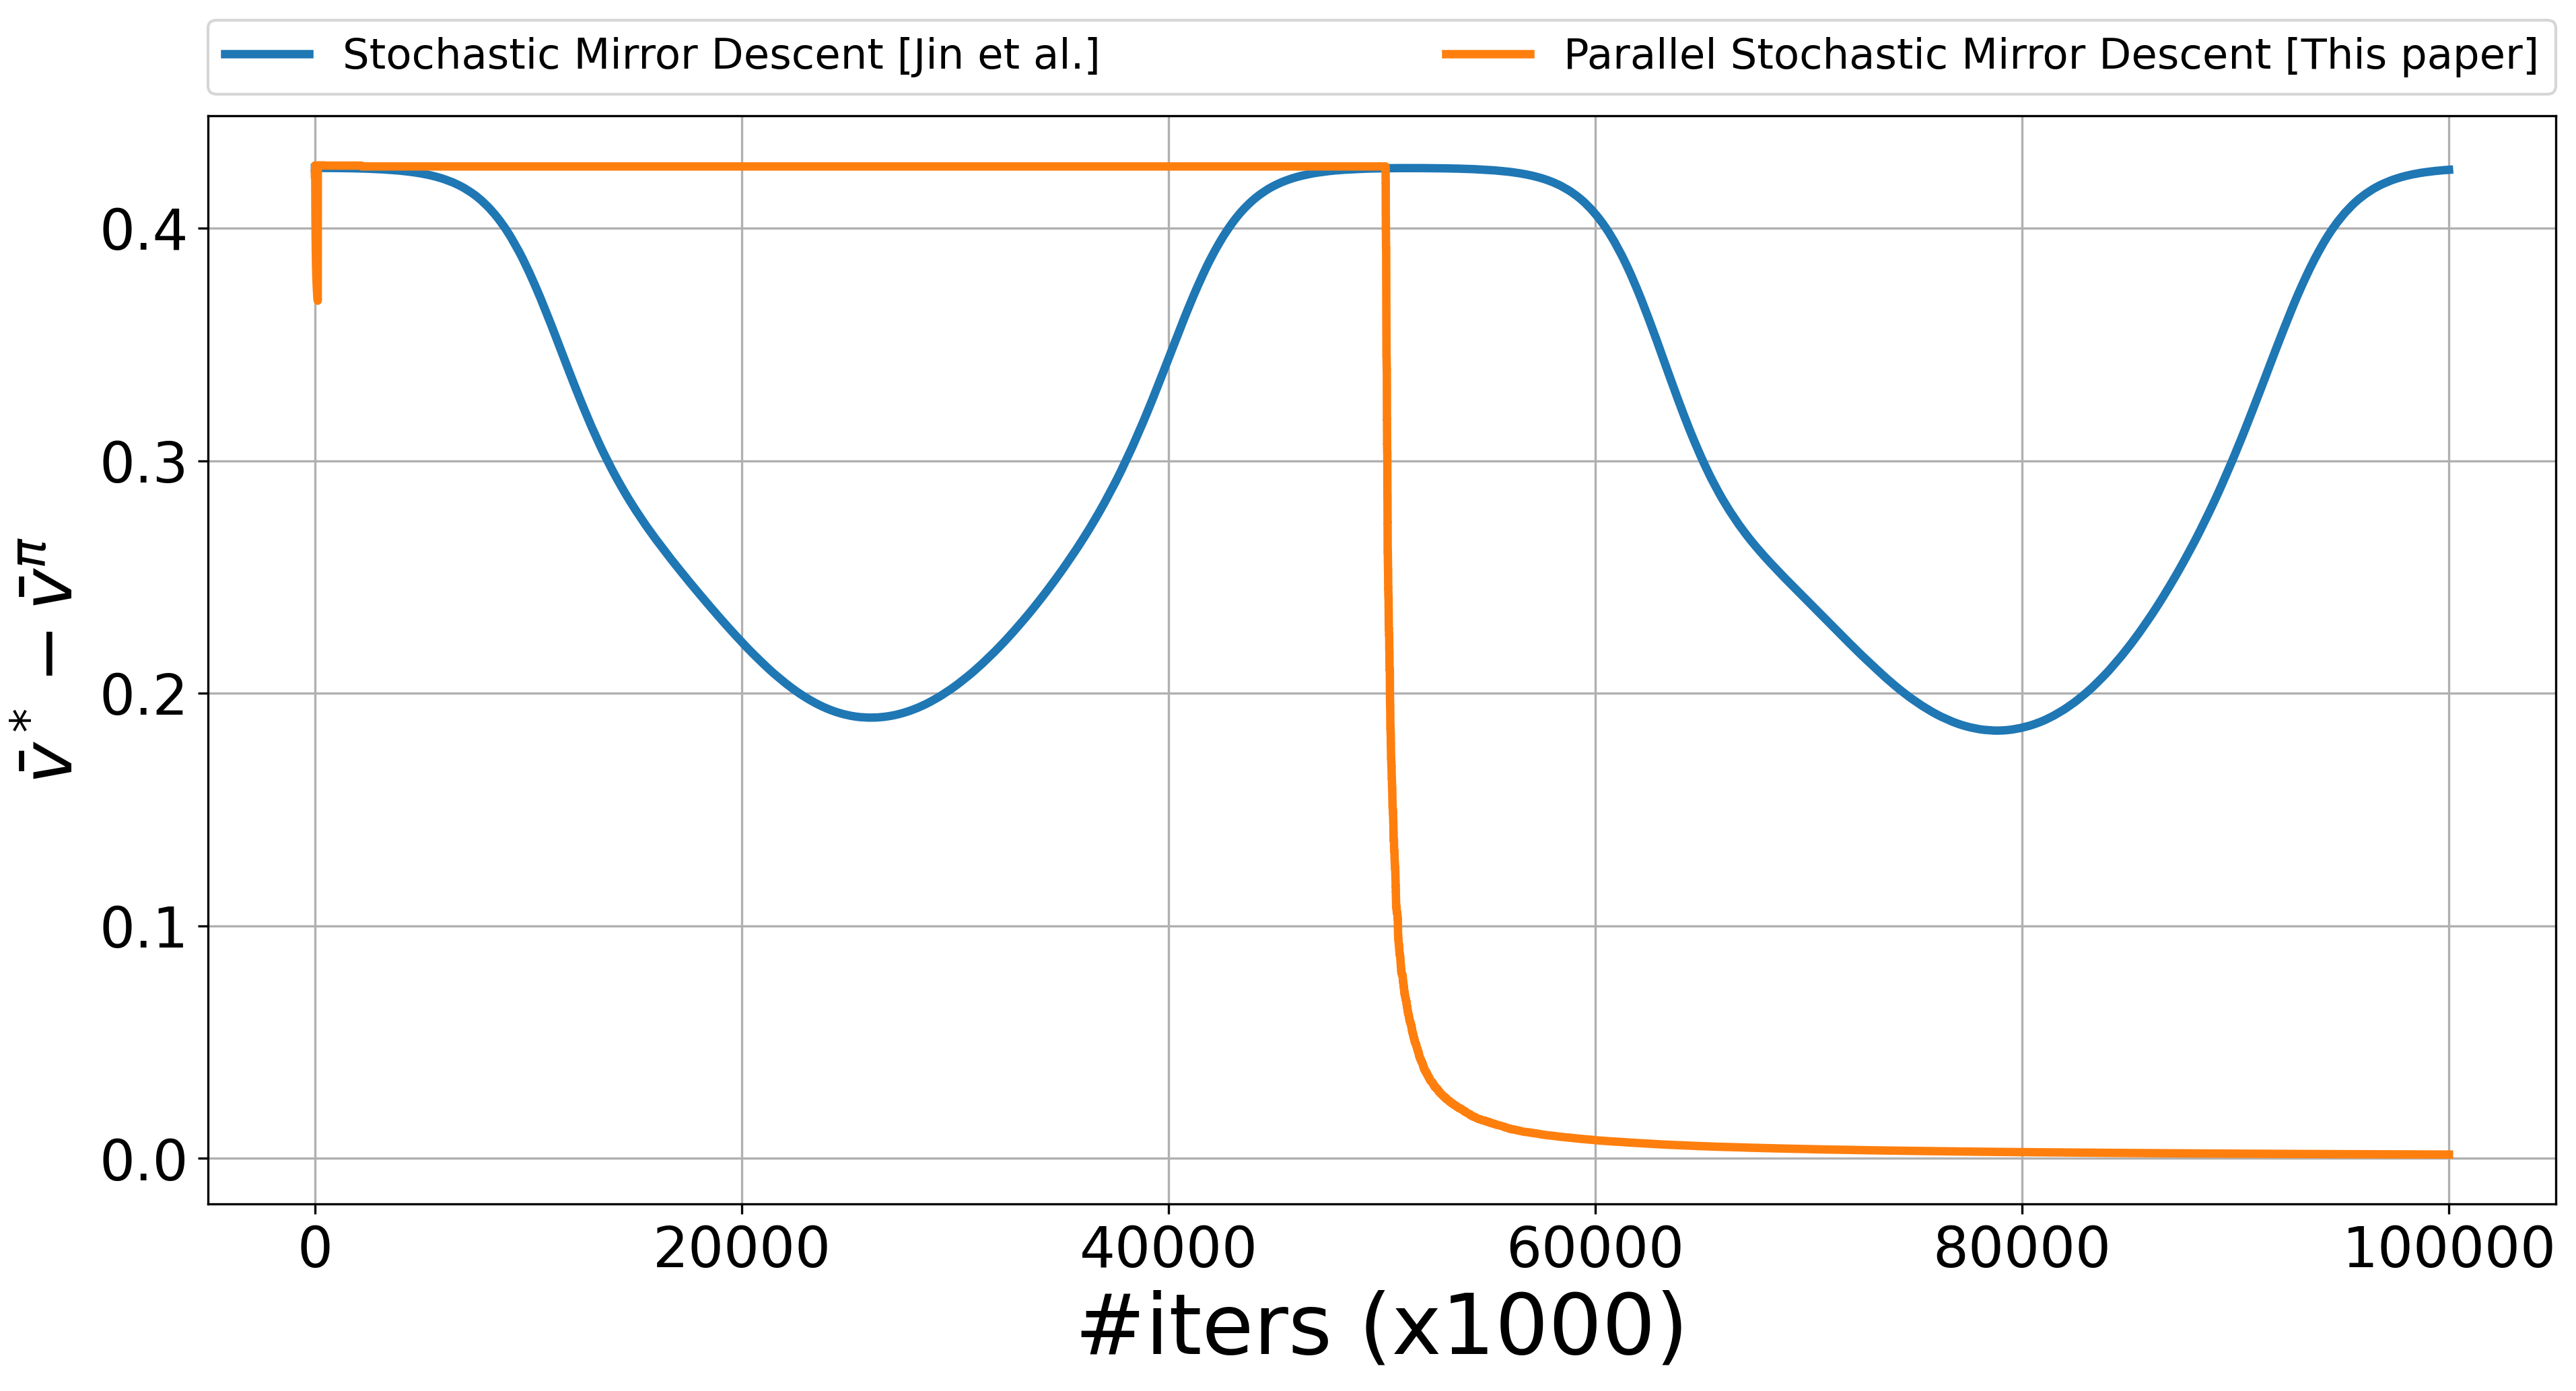

In [69]:
fig = plt.figure(figsize = (15,7), dpi=300)
ax = fig.add_subplot()

xs = np.arange(10001)
k = 0

ax.plot(delta_smd[k:],  linewidth=3, label='Stochastic Mirror Descent [Jin et al.]')
ax.plot(delta_psmd[k:], linewidth=3, label='Parallel Stochastic Mirror Descent [This paper]')


plt.legend(loc="lower left", bbox_to_anchor=(0., 1.02, 1., .102), prop={'size': 15}, ncol=2, mode="expand", borderaxespad=0., frameon=True)


plt.xlabel(r'#iters (x1000)', fontsize=30)
plt.ylabel(r'$\bar v^* - \bar v^\pi$', fontsize=25)

plt.yticks(fontsize=20)

plt.xticks(fontsize=20)

ax.grid()
ax.grid(which='minor',  color = 'k',linestyle = ':')

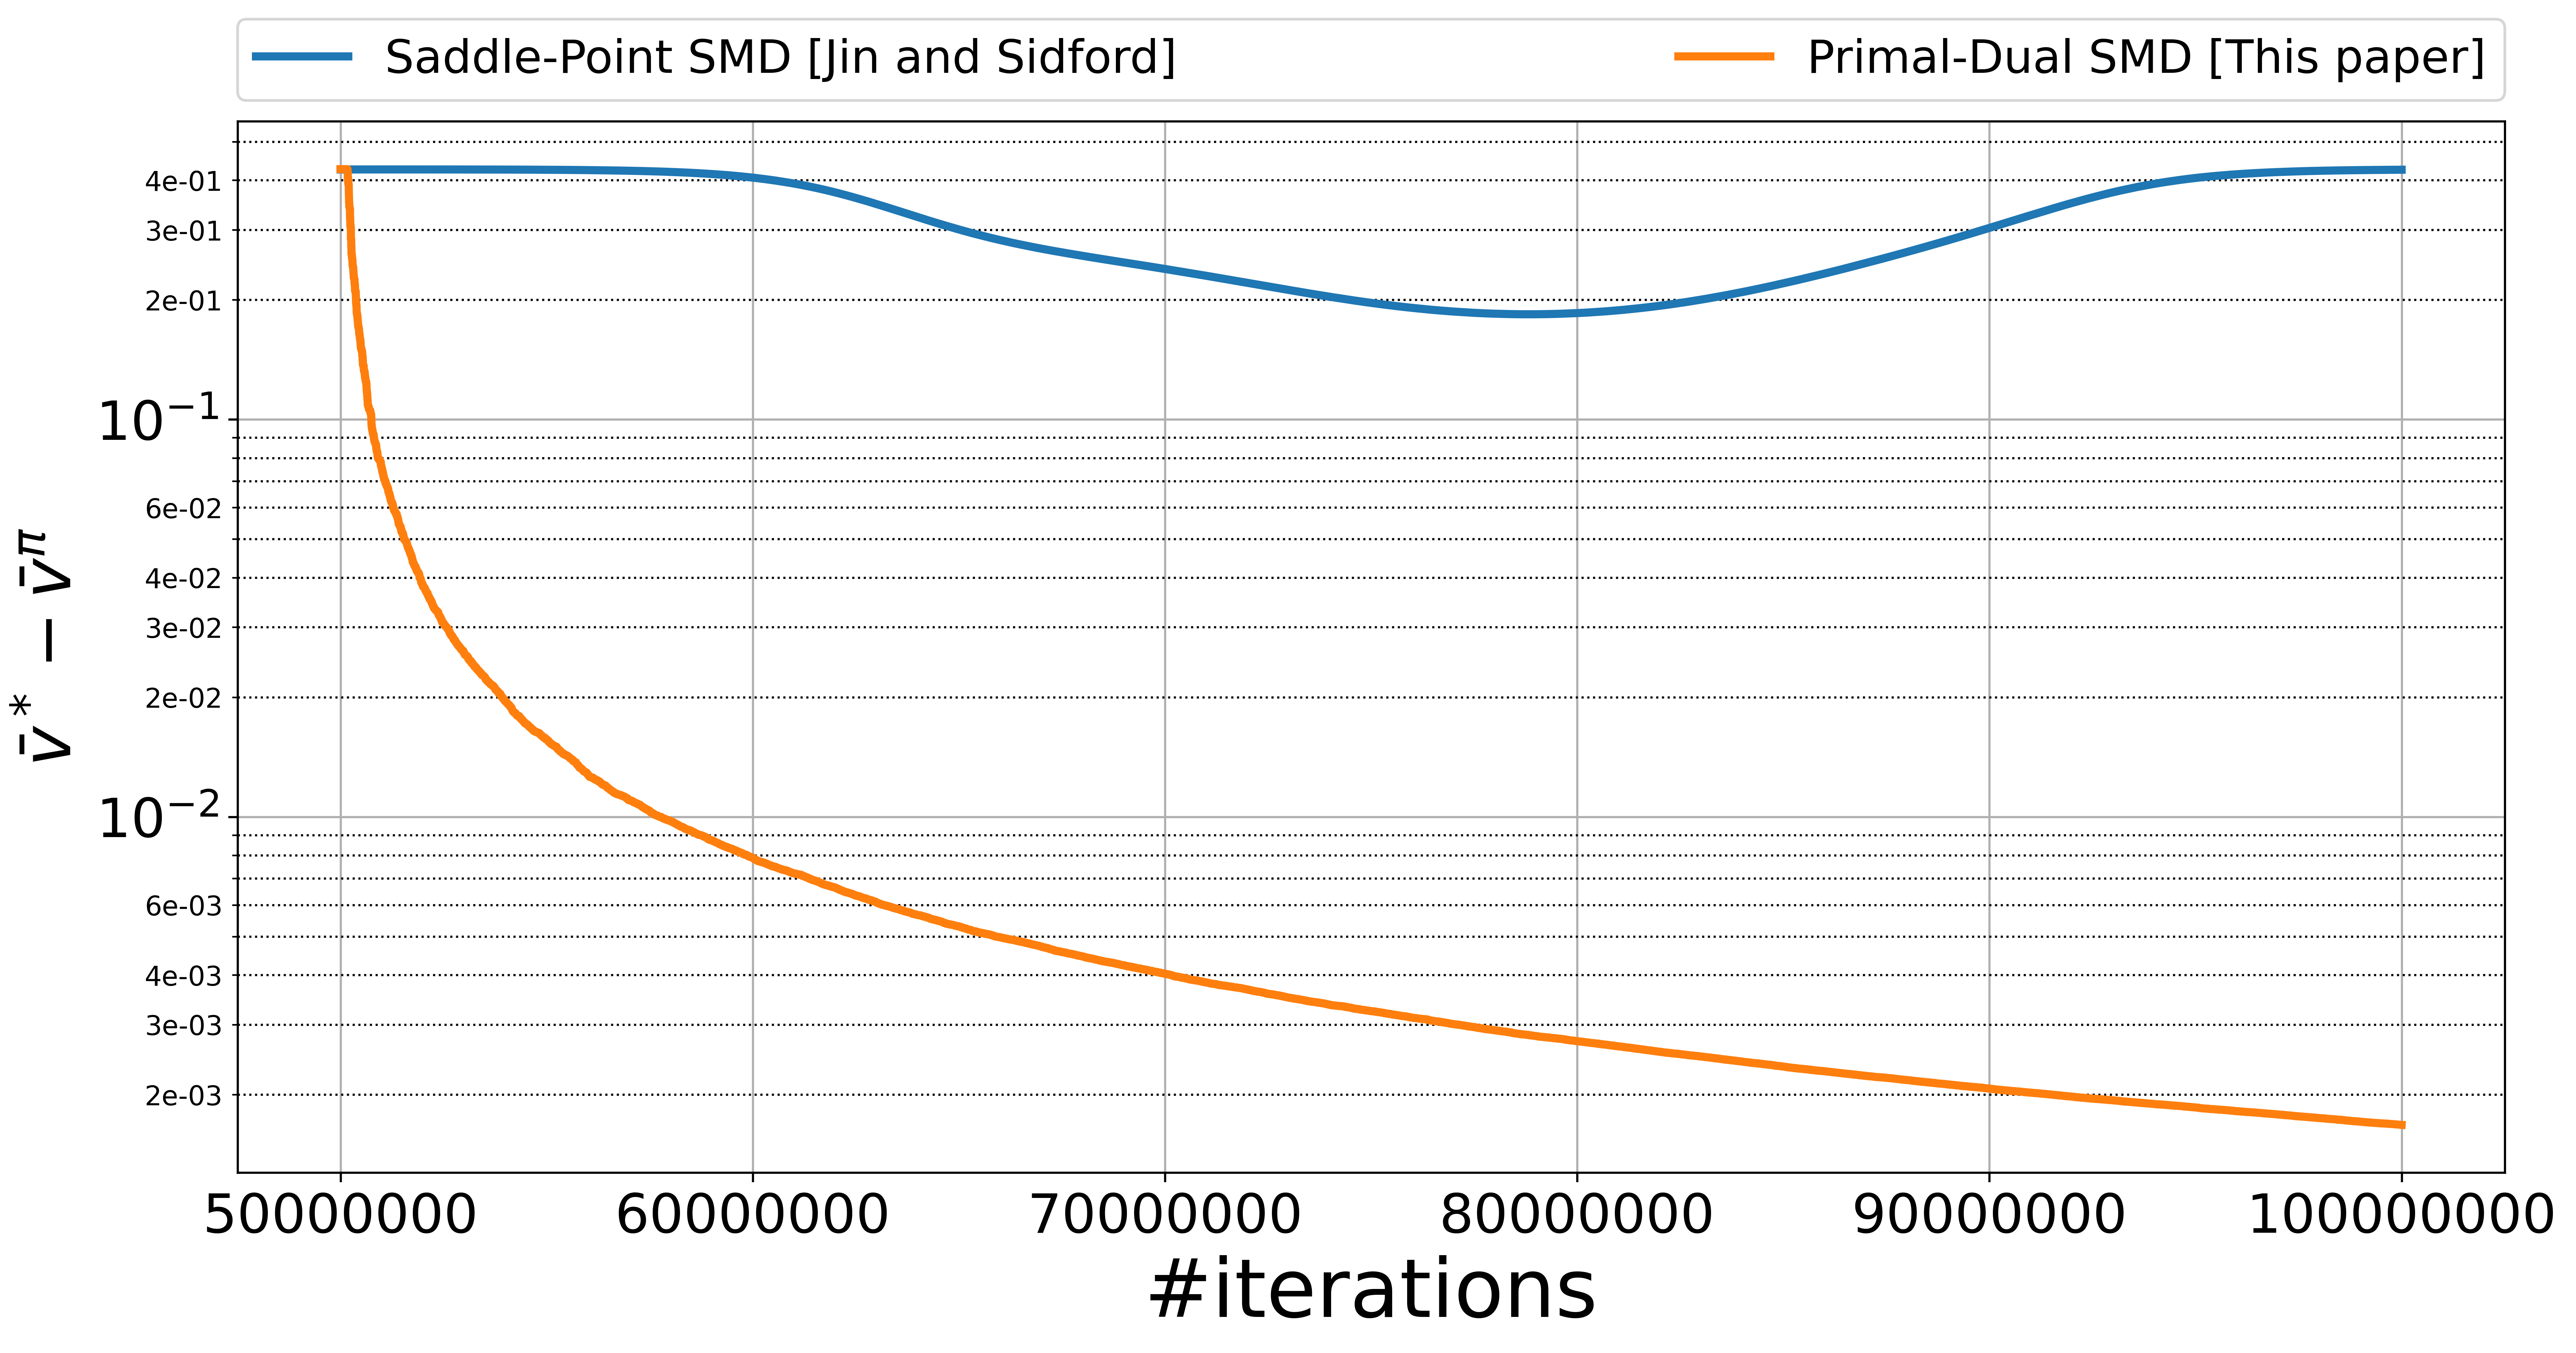

In [74]:
fig = plt.figure(figsize = (15,7), dpi=600)
ax = fig.add_subplot()

xs = np.arange(10001)
k = 50000
to = 100000

ax.plot(1000 * np.arange(k+1, to+1), delta_smd[k:to],  linewidth=3, label='Saddle-Point SMD [Jin and Sidford]')
ax.plot(1000 * np.arange(k+1, to+1), delta_psmd[k:to], linewidth=3, label='Primal-Dual SMD [This paper]')

plt.legend(loc="lower left", bbox_to_anchor=(0., 1.02, 1., .102), prop={'size': 17}, ncol=2, mode="expand", borderaxespad=0., frameon=True)

plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.xlabel(r'#iterations', fontsize=30)
plt.ylabel(r'$\bar v^* - \bar v^\pi$', fontsize=25)

plt.yticks(fontsize=20)
plt.yscale('log')

plt.xticks(fontsize=20)

ax.grid()
ax.grid(which='minor',  color = 'k',linestyle = ':')
ax.yaxis.set_minor_formatter(plt.LogFormatter(minor_thresholds=(10,2)))